In [40]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import mne

In [45]:
with open('raw/W1_C1_EMG_rest.txt', 'r') as file:
    data = np.array(list(csv.reader(file, delimiter = '\t')))

channels = list(data[ 0, : ])
data = data[ 1:, : ].transpose()
sfreq = 20000.0  # Hz

ch_types = [ 'emg' for i in range(0, len(channels)) ]

info = mne.create_info(ch_names = channels, sfreq = sfreq, ch_types = ch_types)
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=30, n_times=200001
    Range : 0 ... 200000 =      0.000 ...    10.000 secs
Ready.


In [46]:
mne.viz.plot_raw(raw, n_channels = len(raw.ch_names), scalings = 1, remove_dc = False)

Using pyopengl with version 3.1.6


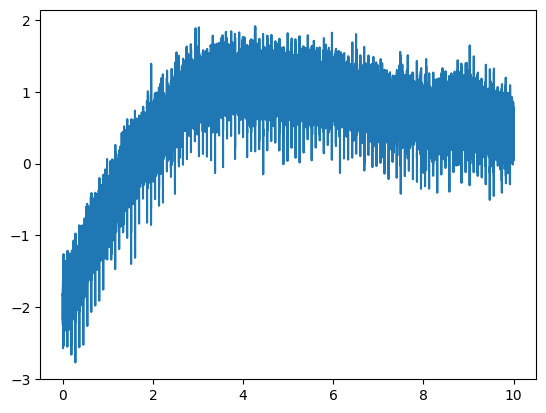

In [47]:
emg_data = raw.get_data(picks = [ channels[ 3 ] ])
times = raw.times
emg_data = emg_data[ 0 ]
times = list(times)
plt.plot(times, emg_data)
plt.show()

Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_83902/1043070993.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(picks = 'emg').plot(picks = 'emg')
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


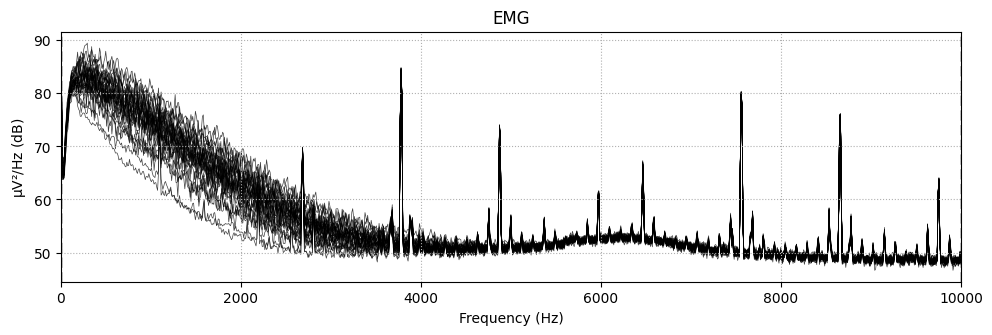

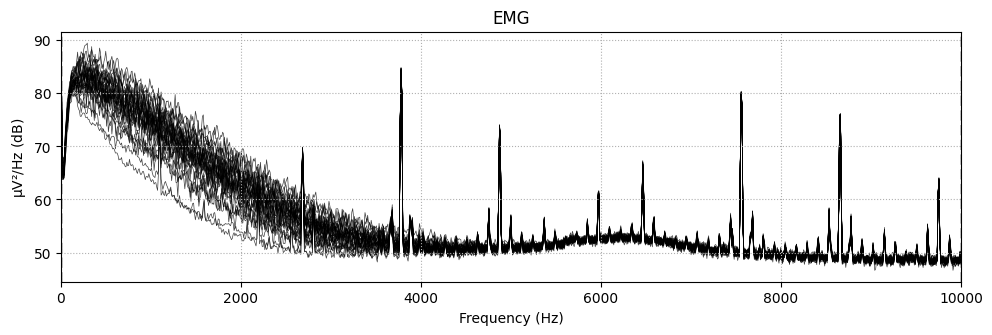

In [48]:
# Periodogram
raw.compute_psd(picks = 'emg').plot(picks = 'emg')

In [49]:
raw.filter(l_freq = 40, h_freq = None, fir_design = 'firwin', picks = 'emg')

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Filter length: 6601 samples (0.330 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


<RawArray | 30 x 200001 (10.0 s), ~45.8 MB, data loaded>

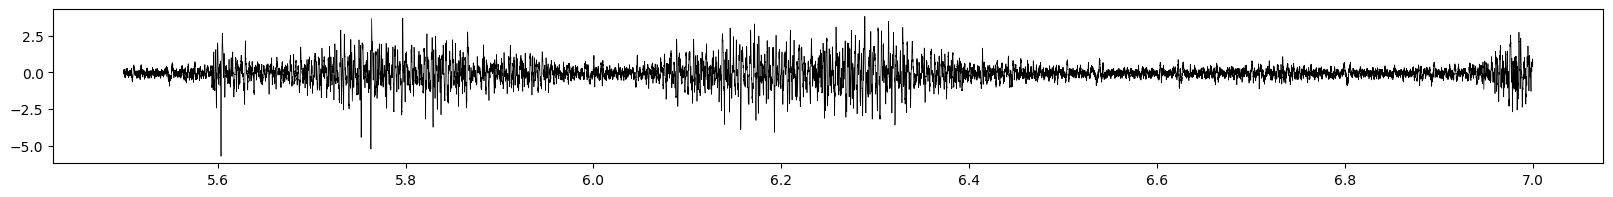

In [62]:
emg_data = raw.get_data(picks = [ channels[ 1 ] ])[0]
times = raw.times
times = list(times)
plt.figure(figsize=(20, 2))
# plt.plot(times, emg_data, linewidth = 0.5, color = 'black')
plt.plot(times[ int(sfreq / 10 * 55) : int(sfreq / 10 * 70) ], emg_data[ int(sfreq / 10 * 55) : int(sfreq / 10 * 70) ], linewidth = 0.5, color = 'black')
plt.show()

In [9]:
mne.viz.plot_raw(raw, n_channels = len(raw.ch_names), scalings = 'auto')

Using pyopengl with version 3.1.6


Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_83902/4030762841.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(picks = channels[ 1 ]).plot(picks = channels[ 1 ])
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


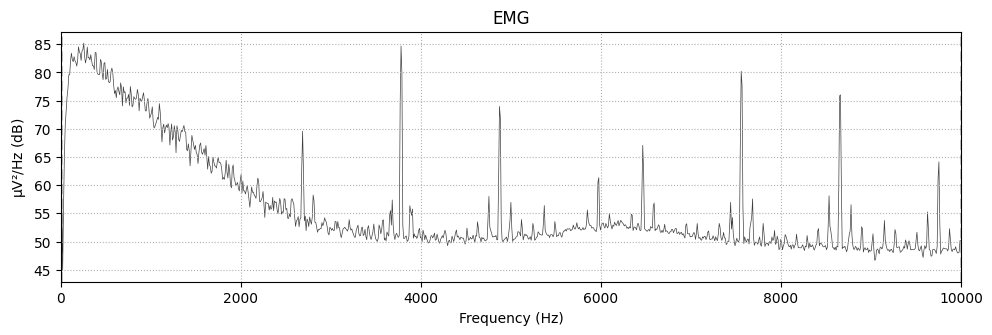

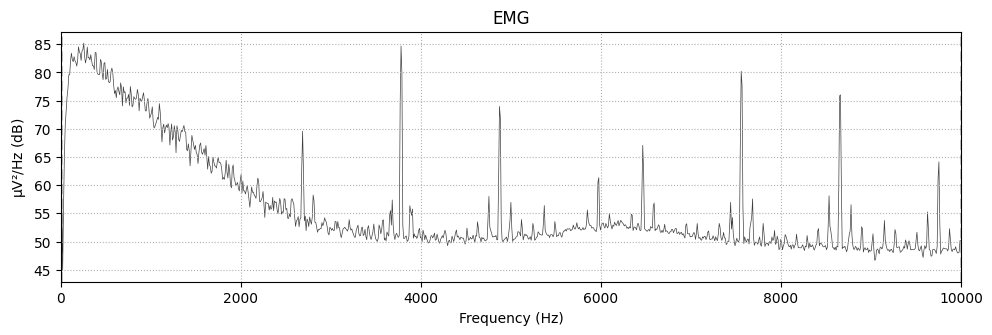

In [57]:
# Periodogram
raw.compute_psd(picks = channels[ 1 ]).plot(picks = channels[ 1 ])

In [119]:
# Questions:
# 1. Experimental design -- what exactly was done with these mice? Is EMG recorded from one cell as well? Do the EMG channels correspond somehow to Vm recordings?
# 2. Data filtering (low, high pass; filter heartbeat?)
# 3. What is considered movement? Is it those bursts of high amplitude signals? Do we consider it movement when there is "movement" in at least one channel?

In [54]:
signal = raw.get_data(picks = [ channels[ 1 ] ])[0]
t = raw.times

In [76]:
# tke = signal[1:-1] ** 2 - signal[:-2] * signal[2:]
tke = signal[1:-1] ** 2 - signal[:-2] * signal[2:]

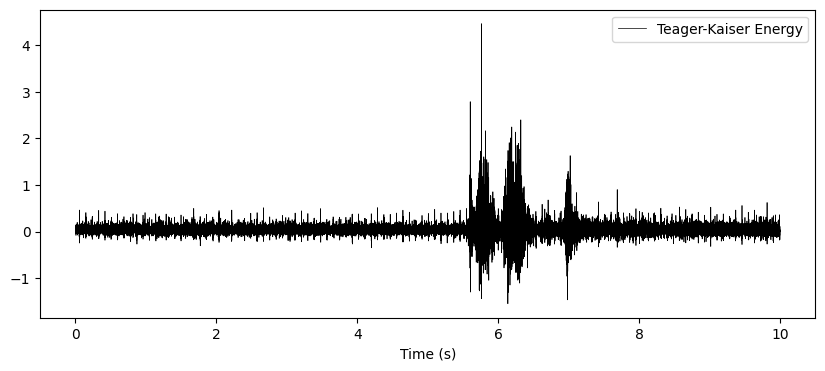

In [77]:
plt.figure(figsize=(10, 4))
# plt.plot(t, signal, label='Original Signal')
plt.plot(t[1:-1], tke, label='Teager-Kaiser Energy', linewidth = 0.5, color = 'black')

# plt.plot(times[ int(sfreq / 10 * 55) : int(sfreq / 10 * 70) ], tke[ int(sfreq / 10 * 55) : int(sfreq / 10 * 70) ], linewidth = 0.5, color = 'black')
# plt.plot(times[ int(sfreq / 10 * 55) : int(sfreq / 10 * 70) ], emg_data[ int(sfreq / 10 * 55) : int(sfreq / 10 * 70) ], linewidth = 0.5, color = 'red')

plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [104]:
tke

array([4.63488083e-05, 4.64319175e-05, 4.61501311e-05, ...,
       2.76222001e-04, 2.75990029e-04, 2.75598474e-04])

In [79]:
len(signal[:-2])

199999